In [1]:
COMMIT_HASH = "9c3ef18c821268297f31d45e36c3b0f2bb538a80"
!git clone https://github.com/r-isachenko/dgm_utils.git
%cd dgm_utils
!git checkout {COMMIT_HASH}
!python3.10 -m pip install ./
%cd ./..
!rm -Rf dgm_utils

Клонирование в «dgm_utils»...
remote: Enumerating objects: 134, done.
remote: Counting objects: 100% (134/134), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 134 (delta 83), reused 89 (delta 43), pack-reused 0 (from 0)
Получение объектов: 100% (134/134), 26.47 КиБ | 13.24 МиБ/с, готово.
Определение изменений: 100% (83/83), готово.
/home/petr/main/mipt/BMM/implicit-reparameterization-trick/code/dgm_utils
Примечание: переключение на «9c3ef18c821268297f31d45e36c3b0f2bb538a80».

Вы сейчас в состоянии «отсоединённого указателя HEAD». Можете осмотреться,
внести экспериментальные изменения и зафиксировать их, также можете
отменить любые коммиты, созданные в этом состоянии, не затрагивая другие
ветки, переключившись обратно на любую ветку.

Если хотите создать новую ветку для сохранения созданных коммитов, можете
сделать это (сейчас или позже), используя команду switch с параметром -c.
Например:

  git switch -c <новая-ветка>

Или отмените эту операцию с помощью:

  git 

In [27]:
from dgm_utils import train_model
from dgm_utils import show_samples, visualize_images, load_dataset
from dgm_utils import BaseModel

import numpy as np
from typing import Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

if torch.cuda.is_available():
    DEVICE = "cuda"
    print('GPU found :)')
else:
    DEVICE = "cpu"
    print('GPU not found :(')

GPU found :)


# ResNetVAE on MNIST 

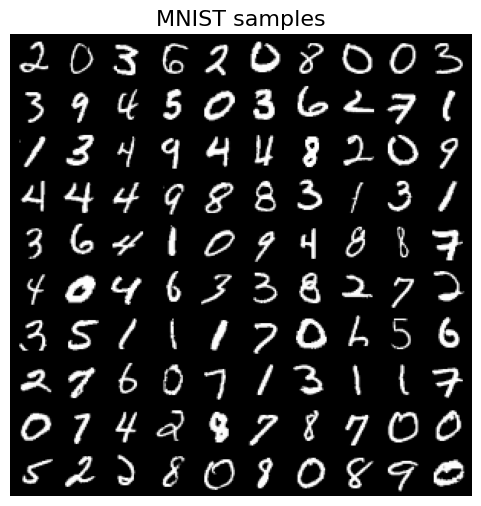

In [28]:
train_data, test_data = load_dataset("mnist", flatten=False, binarize=False)
visualize_images(train_data, "MNIST samples")

Now it is time to define our model. Our model will have the following structure:

* Prior distribution is standard Normal ($p(\mathbf{z}) = \mathcal{N}(0, I)$).
* Variational posterior distribution (or encoder) is $q(\mathbf{z} | \mathbf{x}, \boldsymbol{\phi}) = \mathcal{N}(\boldsymbol{\mu}_{\boldsymbol{\phi}}(\mathbf{x}), \boldsymbol{\Sigma}_{\boldsymbol{\phi}}(\mathbf{x}))$. Here $\boldsymbol{\phi}$ denotes all parameters of the encoder neural network. We will assume that covariance matrice $\boldsymbol{\Sigma}_{\boldsymbol{\phi}}(\mathbf{x})$ is diagonal.
* Generative distribution (or decoder) is $p(\mathbf{x} | \mathbf{z}, \boldsymbol{\theta}) = \mathcal{N}(\boldsymbol{\mu}_{\boldsymbol{\theta}}(\mathbf{z}), \boldsymbol{\Sigma}_{\boldsymbol{\theta}}(\mathbf{z}))$. Here $\boldsymbol{\theta}$ denotes all parameters of the decoder neural network. Please note, that here we will use continuous distribution for our variables $\mathbf{x}$.
* We do not fit the covariance matrix $\boldsymbol{\Sigma}_{\boldsymbol{\theta}}(\mathbf{z})$ in the generative distribution $p(\mathbf{x} | \mathbf{z}, \boldsymbol{\theta})$. We assume that it is identical ($\boldsymbol{\Sigma}_{\boldsymbol{\theta}}(\mathbf{z}) = \mathbf{I}$). We will use the $\boldsymbol{\mu}_{\boldsymbol{\theta}}(\mathbf{z})$ (mean of the generative distribution $p(\mathbf{x} | \mathbf{z}, \boldsymbol{\theta})$) as model samples.
* Our encoder and decoder will be convolutional neural networks.
* Model objective is slightly modified ELBO:
$$
    \mathcal{L}(\boldsymbol{\phi}, \boldsymbol{\theta}) = \mathbb{E}_{q(\mathbf{z} | \mathbf{x}, \boldsymbol{\phi})} \log p(\mathbf{x} | \mathbf{z}, \boldsymbol{\theta}) - \beta * KL (q(\mathbf{z} | \mathbf{x}, \boldsymbol{\phi}) || p(\mathbf{z})).
$$
Here we introduce the parameter $\beta$. It reweights KL term in the total loss. It a standard heuristics that allows to get more accurate model. In this exercise you have to play with it, starting with the value $\beta = 1$ (standard ELBO).

To make the expectation is independent of parameters $\boldsymbol{\phi}$, we will use reparametrization trick.


To calculate the loss, we should derive
- $\log p(\mathbf{x} | \mathbf{z}, \boldsymbol{\theta})$, note that generative distribution is $\mathcal{N}(\boldsymbol{\mu}_{\boldsymbol{\theta}}(\mathbf{z}), \boldsymbol{\Sigma}_{\boldsymbol{\theta}}(\mathbf{z}))$.
- KL between $q(\mathbf{z} | \mathbf{x}, \boldsymbol{\phi}) = \mathcal{N}(\boldsymbol{\mu}_{\boldsymbol{\phi}}(\mathbf{x}), \boldsymbol{\Sigma}_{\boldsymbol{\phi}}(\mathbf{x}))$ and $\mathcal{N}(0, \mathbf{I})$.

Let start with the helper functions.

In [37]:
def get_normal_KL(
    mean_1: torch.Tensor,
    log_std_1: torch.Tensor,
    mean_2: Optional[torch.Tensor] = None,
    log_std_2: Optional[torch.Tensor] = None,
) -> torch.Tensor:
    """
    :Parameters:
    mean_1: means of normal distributions (1)
    log_std_1 : standard deviations of normal distributions (1)
    mean_2: means of normal distributions (2)
    log_std_2 : standard deviations of normal distributions (2)
    :Outputs:
    kl divergence of the normal distributions (1) and normal distributions (2)
    ---
    This function should return the value of KL(p1 || p2),
    where p1 = Normal(mean_1, exp(log_std_1) ** 2), p2 = Normal(mean_2, exp(log_std_2) ** 2).
    If mean_2 and log_std_2 are None values, we will use standard normal distribution.
    Note that we consider the case of diagonal covariance matrix.
    """
    if mean_2 is None:
        mean_2 = torch.zeros_like(mean_1)
    if log_std_2 is None:
        log_std_2 = torch.zeros_like(log_std_1)
    assert mean_1.shape == log_std_1.shape == mean_2.shape == log_std_2.shape
    std_1 = torch.exp(log_std_1)
    std_2 = torch.exp(log_std_2)

    var_1 = std_1 ** 2
    var_2 = std_2 ** 2

    D_KL = 0.5 * (
        (var_1 / var_2) +
        ((mean_2 - mean_1) ** 2 / var_2) -
        1 +
        torch.log(var_2 / var_1)
    )
    return D_KL


def test_KL():
    assert np.isclose(
        get_normal_KL(
            torch.tensor(2), torch.tensor(3), torch.tensor(0), torch.tensor(0)
        ).numpy(),
        200.2144,
        rtol=1e-3,
    )
    assert np.isclose(
        get_normal_KL(
            torch.tensor(2), torch.tensor(3), torch.tensor(4), torch.tensor(5)
        ).numpy(),
        1.50925,
        rtol=1e-3,
    )
    assert np.allclose(
        get_normal_KL(
            torch.tensor((10, 10)), torch.tensor((2, 4)), torch.tensor((3, 5))
        ).numpy(),
        [49.2990, 1498.479],
        rtol=1e-3,
    )


test_KL()

In [ ]:
def get_normal_nll(
    x: torch.Tensor, mean: torch.Tensor, log_std: torch.Tensor
) -> torch.Tensor:
    """
    This function should return the negative log likelihood log p(x),
    where p(x) = Normal(x | mean, exp(log_std) ** 2).
    Note that we consider the case of diagonal covariance matrix.
    """
    std = torch.exp(log_std)
    log_likelihood = torch.log(
        1 / ((2 * torch.pi)**0.5 * std) *
        torch.exp(-0.5 * ((x - mean) ** 2) / (std ** 2))
    )
    return -log_likelihood


def test_NLL():
    assert np.isclose(
        get_normal_nll(torch.tensor(2), torch.tensor(2), torch.tensor(3)).numpy(),
        3.9189,
        rtol=1e-3,
    )
    assert np.isclose(
        get_normal_nll(torch.tensor(5), torch.tensor(-3), torch.tensor(6)).numpy(),
        6.9191,
        rtol=1e-3,
    )
    assert np.allclose(
        get_normal_nll(
            torch.tensor((10, 10)), torch.tensor((2, 4)), torch.tensor((3, 5))
        ).numpy(),
        np.array([3.9982, 5.9197]),
        rtol=1e-3,
    )


test_NLL()

Let define our encoder and decoder neural networks. We will use ResNet-like encoder and decoder.

First of all let define basic ResNet block. It will be the basic block for our encoder.

In [72]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, final_relu=True):
        super().__init__()
        self.final_relu = final_relu
        out_padding = int((kernel_size - 1) / 2)

        if stride == 1:
          padding = int((kernel_size - 1) / 2)
        else:
          padding = int((kernel_size - stride) / 2) + 1

        self.residual = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=out_padding)
        )
        self.skip = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
        )
        self.gelu = nn.GELU()
        if final_relu:
          self.relu2 = nn.ReLU()

    def forward(self, x):
        result = self.gelu(self.residual(x) + self.skip(x))
        if self.final_relu:
            result = self.relu2(result)
        return result


def test_resnet_block():
    test_inp = torch.randn(5, 64, 128, 128)

    for out_channels in [64, 128]:
        for kernel_size in [3, 5, 7]:
            for stride in [1, 2, 4]:
                resnet_block = ResNetBlock(in_channels=64, out_channels=out_channels,
                                        kernel_size=kernel_size, stride=stride)
                assert list(resnet_block(test_inp).shape) == [5, out_channels, 128 // stride, 128 // stride]


test_resnet_block()

Now let define basic ResNet block. It will be the basic block for our decoder.

In [73]:
class ResNetTransposeBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, final_relu=True):
        super().__init__()
        self.final_relu = final_relu
        if stride == 1:
            out_padding = kernel_size // 2 + 1
            padding = (kernel_size - 1) // 2
        else:
            out_padding = kernel_size - 1
            padding = (kernel_size - stride) // 2

        self.f = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        )
        self.conv = nn.Sequential(
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=out_padding, dilation=2)
        )
        if self.final_relu:
          self.relu1 = nn.ReLU()

    def forward(self, x):
        f = self.f(x)
        result = self.conv(f) + f
        if self.final_relu:
            result = self.relu1(result)
        return result


def test_resnet_transposed_block():
    test_inp = torch.randn(5, 64, 14, 14)
    for out_channels in [32, 64, 128]:
        for kernel_size in [3, 4, 6]:
            for stride in [1, 2]:
                if (stride + kernel_size) % 2 != 0:
                    continue
                resnet_block = ResNetTransposeBlock(
                    in_channels=64, out_channels=out_channels, kernel_size=kernel_size, stride=stride)
                # print(resnet_block(test_inp).shape)
                assert list(resnet_block(test_inp).shape) == [5, out_channels, 14 * stride, 14 * stride]


test_resnet_transposed_block()

Now we are to define our encoder and decoder.

In [74]:
class ConvResNetEncoder(nn.Module):
    def __init__(self, input_shape, n_latent):
        super().__init__()
        self.input_shape = input_shape
        self.n_latent = n_latent
        self.encoder = self.cnn_layers = nn.Sequential(
            ResNetBlock(input_shape[0], 8, 3, 1, True),
            ResNetBlock(8, 16, 3, 1, True),
            ResNetBlock(16, 64, 5, 2, True),
            ResNetBlock(64, 128, 5, 2, False),
            nn.Flatten(),
            nn.Linear(128 * (input_shape[1] // 4) * (input_shape[2] // 4), 4096), 
            nn.ReLU(),
            nn.Linear(4096, n_latent * 2)
        )

    def forward(self, x):
        output = self.encoder(x)
        mu, log_std = output.chunk(2, dim=1)

        return mu, log_std


class ConvResNetDecoder(nn.Module):
    def __init__(self, n_latent, output_shape):
        super().__init__()
        self.n_latent = n_latent
        self.output_shape = output_shape
        self.decoder = nn.Sequential(
            nn.Linear(n_latent, 4096),
            nn.ReLU(),
            nn.Linear(4096, 128 * (output_shape[1] // 4) * (output_shape[2] // 4)),
            nn.ReLU(),
            nn.Unflatten(1, torch.Size((128, output_shape[1] // 4, output_shape[2] // 4))),
            ResNetTransposeBlock(128, 64, 4, 2, final_relu=True),
            ResNetTransposeBlock(64, 16, 4, 2, final_relu=True),
            ResNetTransposeBlock(16, 8, 3, 1, final_relu=True),
            ResNetTransposeBlock(8, self.output_shape[0], 3, 1, final_relu=False)
        )

    def forward(self, z):
        out = self.decoder(z)
        return out


def test_convresnet_models():
    test_enc = ConvResNetEncoder((1, 28, 28), n_latent=10)
    inp = torch.randn((4, 1, 28, 28))
    mu, std = test_enc(inp)
 
    assert list(mu.shape) == [4, 10]
    assert list(std.shape) == [4, 10]

    test_dec = ConvResNetDecoder(10, (1, 28, 28))
    inp = torch.randn(4, 10)
    print(test_dec(inp).shape)
    assert list(test_dec(inp).shape) == [4, 1, 28, 28]


test_convresnet_models()

torch.Size([4, 1, 28, 28])


We are ready to implement VAE model for image dataset.

In [75]:
import sys
sys.path.append('../src')
from irt.distributions import Normal

In [78]:
class ConvResNetVAE(BaseModel):
    def __init__(self, input_shape: tuple, n_latent: int, beta: float = 1) -> None:
        super().__init__()
        assert len(input_shape) == 3

        self.input_shape = input_shape
        self.n_latent = n_latent
        self.beta = beta

        self.encoder = ConvResNetEncoder(input_shape, n_latent)
        self.decoder = ConvResNetDecoder(n_latent, input_shape)

    def prior(self, n: int) -> torch.Tensor:
        z = torch.randn(n, self.n_latent)
        z = z.to(self.device)
        return z

    def forward(self, x: torch.Tensor) -> tuple:
        mu_z, log_std_z = self.encoder(x)
        z = Normal(mu_z, torch.exp(log_std_z)).rsample()
        x_recon = self.decoder(z)
        return mu_z, log_std_z, x_recon

    def loss(self, x: torch.Tensor) -> dict:
        mu_z, log_std_z, x_recon = self.forward(x)
        recon_loss = get_normal_nll(x, x_recon, torch.zeros_like(x_recon)).sum(dim=(1,2,3)).mean()
        kl_loss = get_normal_KL(mu_z, log_std_z).sum(dim=1).mean()
        return {
            "elbo_loss": recon_loss + self.beta * kl_loss,
            "recon_loss": recon_loss,
            "kl_loss": kl_loss,
        }

    def sample(self, n: int) -> np.ndarray:
        with torch.no_grad():
            sample = self.prior(n)
            x_recon = self.decoder(sample)
            samples = torch.clamp(x_recon, -1, 1)
        return samples.cpu().numpy() * 0.5 + 0.5

That is all! We are ready to train our model.

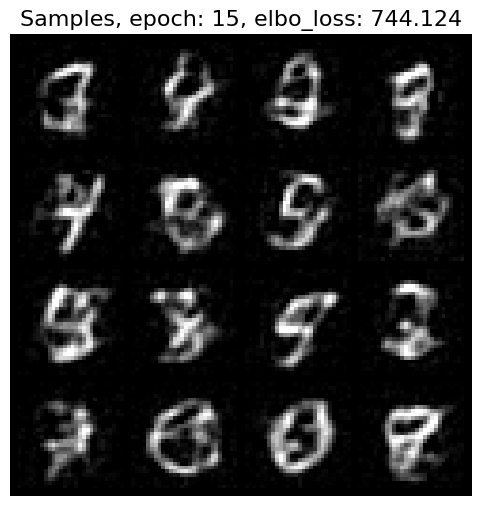

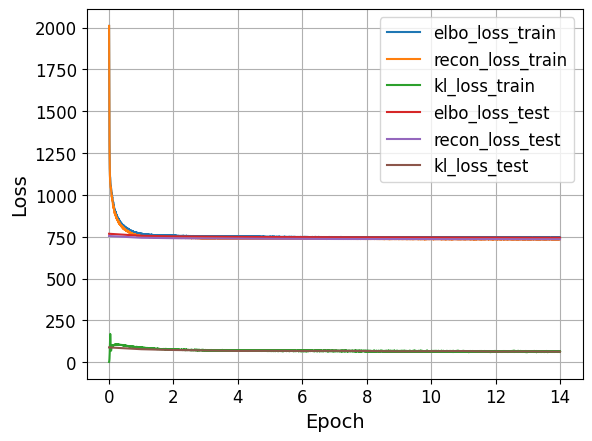

End of the training


In [79]:
BATCH_SIZE = 128 
EPOCHS = 15
LR = 1e-4
N_LATENS = 64
BETA = 0.15

centered_train_data = train_data * 2 - 1
centered_test_data = test_data * 2 - 1

train_loader = data.DataLoader(centered_train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(centered_test_data, batch_size=BATCH_SIZE)

model = ConvResNetVAE((1, 28, 28), N_LATENS, BETA)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

train_model(
    model,
    train_loader,
    test_loader,
    epochs=EPOCHS,
    optimizer=optimizer,
    device=DEVICE,
    n_samples=16,
    visualize_samples=True,
    loss_key="elbo_loss"
)

Now we could visualize the model outputs.

1. We could sample new images from our model (sample latent variable from the prior and apply the decoder).
2. We could visualize image reconstructions (apply the encoder and the decoder to the fixed image).
3. Visualize interpolations (apply the encoder to two images $\mathbf{x}_1$ and $\mathbf{x}_2$ to obtain the latent variables $\mathbf{z}_1$ and $\mathbf{z}_2$, apply the decoder to the latent variables $\mathbf{z}$ lying on the segment between $\mathbf{z}_1$ and $\mathbf{z}_2$).

**Note:** it is ok that your samples are blurry. We do not use difficult architectures and do not tune hyperparameters carefully.

In [39]:
torch.save(model, 'vae.pth')

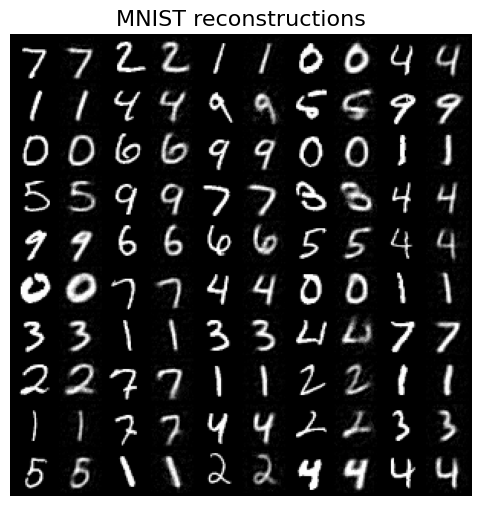

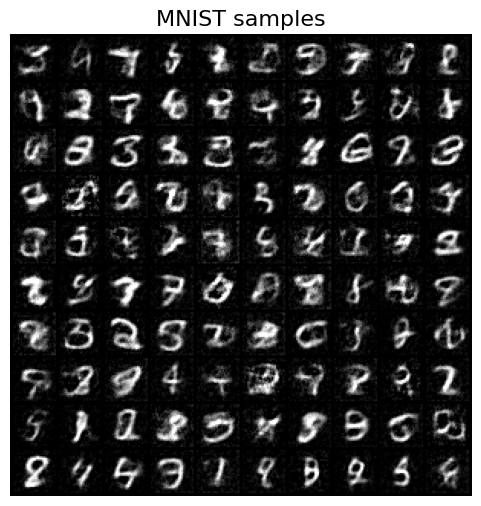

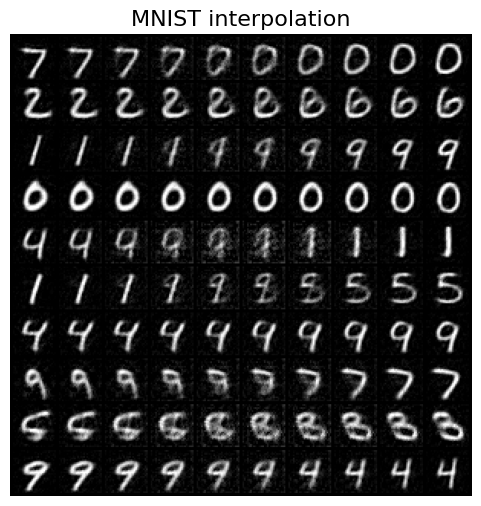

In [40]:
samples = model.sample(100)

x = next(iter(test_loader))[:50]

x = x.to(model.device)

with torch.no_grad():
    z, _ = model.encoder(x)
    x_recon = torch.clamp(model.decoder(z), -1, 1)
reconstructions = torch.stack((x, x_recon), dim=1).view(-1, 1, 28, 28) * 0.5 + 0.5
reconstructions = reconstructions.cpu().numpy()

x = next(iter(test_loader))[:20]
x = x.to(model.device)
with torch.no_grad():
    z, _ = model.encoder(x)
    z1, z2 = z.chunk(2, dim=0)
    interps = [model.decoder(z1 * (1 - alpha) + z2 * alpha) for alpha in np.linspace(0, 1, 10)]
    interps = torch.stack(interps, dim=1).view(-1, 1, 28, 28)
    interps = torch.clamp(interps, -1, 1) * 0.5 + 0.5
interps = interps.cpu().numpy()

show_samples(reconstructions, 'MNIST reconstructions')
show_samples(samples, 'MNIST samples')
show_samples(interps, 'MNIST interpolation')

### Here we apply implicit reparametrisatioin of Gamma distribution

In [ ]:
def get_gamma_KL(
    alpha_1: torch.Tensor,
    beta_1: torch.Tensor,
    alpha_2: Optional[torch.Tensor] = None,
    beta_2: Optional[torch.Tensor] = None,
) -> torch.Tensor:
    """
    Calculates the KL divergence between two Gamma distributions.

    Args:
        alpha_1: Shape parameter of the first Gamma distribution.
        beta_1: Rate parameter of the first Gamma distribution.
        alpha_2: Shape parameter of the second Gamma distribution (default: 1).
        beta_2: Rate parameter of the second Gamma distribution (default: 1).

    Returns:
        The KL divergence KL(Gamma(alpha_1, beta_1) || Gamma(alpha_2, beta_2)).
    """
    if alpha_2 is None:
        alpha_2 = torch.ones_like(alpha_1)
    if beta_2 is None:
        beta_2 = torch.ones_like(beta_1)

    assert alpha_1.shape == beta_1.shape == alpha_2.shape == beta_2.shape
    assert torch.all(alpha_1 > 0) and torch.all(beta_1 > 0) and torch.all(alpha_2 > 0) and torch.all(beta_2 > 0)

    # Use the formula for KL divergence between Gamma distributions
    kl_divergence = (
        alpha_2 * torch.log(beta_1)
        - alpha_2 * torch.log(beta_2)
        + (alpha_1 - alpha_2) * torch.digamma(alpha_1)
        + torch.lgamma(alpha_2)
        - torch.lgamma(alpha_1)
        + alpha_1 * (beta_2 / beta_1 - 1)
    )
    return kl_divergence

In [127]:
from irt.distributions import Gamma

class GammaConvResNetVAE(BaseModel):
    def __init__(self, input_shape: tuple, n_latent: int, beta: float = 1) -> None:
        super().__init__()
        assert len(input_shape) == 3

        self.input_shape = input_shape
        self.n_latent = n_latent
        self.beta = beta

        self.encoder = ConvResNetEncoder(input_shape, n_latent)
        self.decoder = ConvResNetDecoder(n_latent, input_shape)

    def prior(self, n: int) -> torch.Tensor:
        z = torch.randn(n, self.n_latent)
        z = z.to(self.device)
        return z

    def forward(self, x: torch.Tensor) -> tuple:
        log_alpha, log_beta = self.encoder(x)
        z = Gamma(torch.exp(log_alpha), torch.exp(log_beta)).rsample()
        x_recon = self.decoder(z)
        return log_alpha, log_beta, x_recon

    def loss(self, x: torch.Tensor) -> dict:
        log_alpha, log_beta, x_recon = self.forward(x)
        recon_loss = get_normal_nll(x, x_recon, torch.zeros_like(x_recon)).sum(dim=(1,2,3)).mean()
        kl_loss = get_gamma_KL(torch.exp(log_alpha), torch.exp(log_beta)).sum(dim=1).mean()
        return {
            "elbo_loss": recon_loss + self.beta * kl_loss,
            "recon_loss": recon_loss,
            "kl_loss": kl_loss,
        }

    def sample(self, n: int) -> np.ndarray:
        with torch.no_grad():
            sample = self.prior(n)
            x_recon = self.decoder(sample)
            samples = torch.clamp(x_recon, -1, 1)
        return samples.cpu().numpy() * 0.5 + 0.5

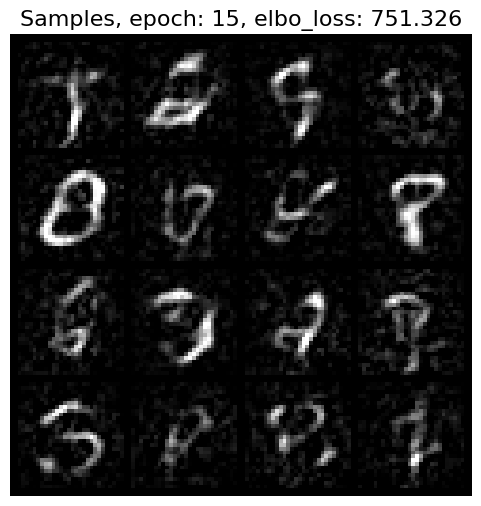

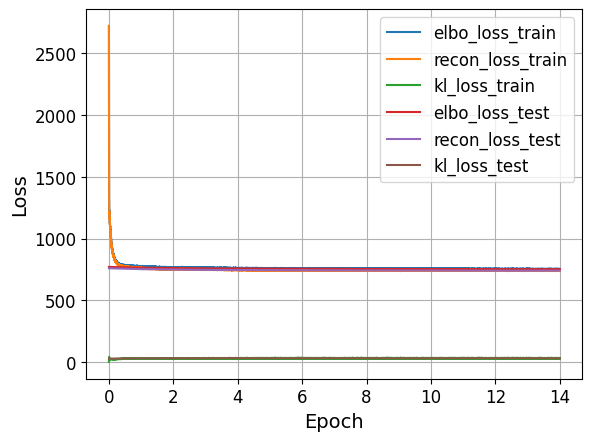

End of the training


In [183]:
BATCH_SIZE = 32 
EPOCHS = 15
LR = 1e-4
N_LATENS = 32
BETA = 0.4

centered_train_data = train_data * 2 - 1
centered_test_data = test_data * 2 - 1

train_loader = data.DataLoader(centered_train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(centered_test_data, batch_size=BATCH_SIZE)

model = GammaConvResNetVAE((1, 28, 28), N_LATENS, BETA)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

train_model(
    model,
    train_loader,
    test_loader,
    epochs=EPOCHS,
    optimizer=optimizer,
    device=DEVICE,
    n_samples=16,
    visualize_samples=True,
    loss_key="elbo_loss"
)

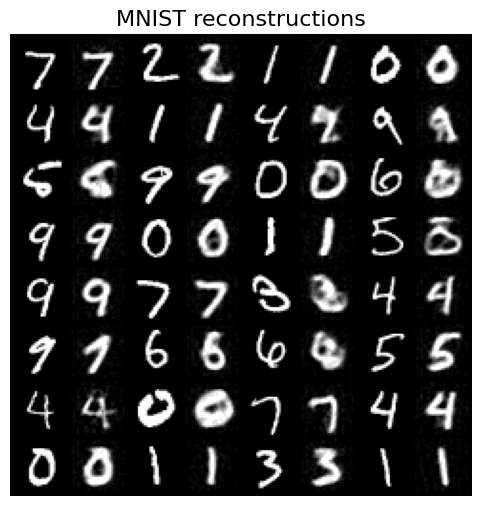

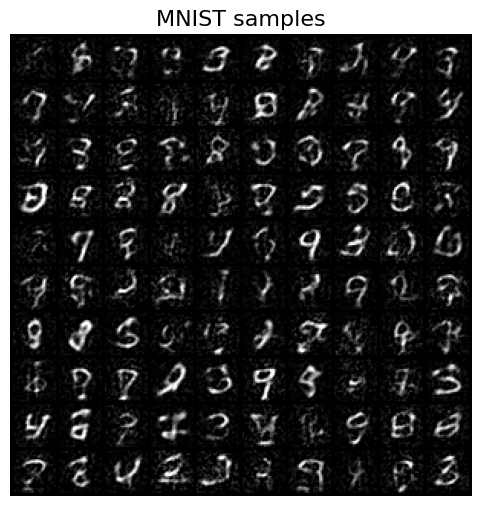

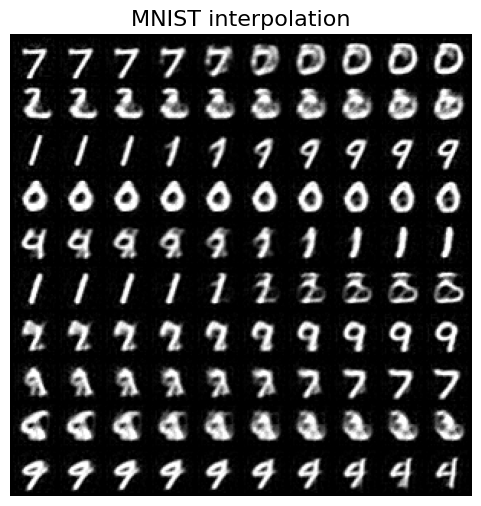

In [184]:
samples = model.sample(100)

x = next(iter(test_loader))[:50]

x = x.to(model.device)

with torch.no_grad():
    z, _ = model.encoder(x)
    x_recon = torch.clamp(model.decoder(z), -1, 1)
reconstructions = torch.stack((x, x_recon), dim=1).view(-1, 1, 28, 28) * 0.5 + 0.5
reconstructions = reconstructions.cpu().numpy()

x = next(iter(test_loader))[:20]
x = x.to(model.device)
with torch.no_grad():
    z, _ = model.encoder(x)
    z1, z2 = z.chunk(2, dim=0)
    interps = [model.decoder(z1 * (1 - alpha) + z2 * alpha) for alpha in np.linspace(0, 1, 10)]
    interps = torch.stack(interps, dim=1).view(-1, 1, 28, 28)
    interps = torch.clamp(interps, -1, 1) * 0.5 + 0.5
interps = interps.cpu().numpy()

show_samples(reconstructions, 'MNIST reconstructions')
show_samples(samples, 'MNIST samples')
show_samples(interps, 'MNIST interpolation')

# Try the same for Beta distribution

In [199]:
def get_beta_KL(log_alpha, log_beta,
             prior_alpha=None, prior_beta=None):
    """Calculate KL divergence between given and prior beta distributions.
    """
    alpha = torch.exp(log_alpha)
    beta = torch.exp(log_beta)

    if prior_alpha is None:
        prior_alpha = torch.ones_like(alpha)
    if prior_beta is None:
        prior_beta = torch.ones_like(beta)

    kl = (alpha - prior_alpha)*(torch.digamma(alpha) - torch.digamma(alpha + beta))
    kl += (beta - prior_beta)*(torch.digamma(beta) - torch.digamma(alpha + beta))
    kl += torch.lgamma(beta + alpha) - torch.lgamma(alpha) - torch.lgamma(beta) 
    kl += torch.lgamma(prior_alpha) + torch.lgamma(prior_beta) - torch.lgamma(prior_beta + prior_alpha)
    return kl

In [200]:
from irt.distributions import Gamma

class GammaConvResNetVAE(BaseModel):
    def __init__(self, input_shape: tuple, n_latent: int, beta: float = 1) -> None:
        super().__init__()
        assert len(input_shape) == 3

        self.input_shape = input_shape
        self.n_latent = n_latent
        self.beta = beta

        self.encoder = ConvResNetEncoder(input_shape, n_latent)
        self.decoder = ConvResNetDecoder(n_latent, input_shape)

    def prior(self, n: int) -> torch.Tensor:
        z = torch.randn(n, self.n_latent)
        z = z.to(self.device)
        return z

    def forward(self, x: torch.Tensor) -> tuple:
        log_alpha, log_beta = self.encoder(x)
        z = Gamma(torch.exp(log_alpha), torch.exp(log_beta)).rsample()
        x_recon = self.decoder(z)
        return log_alpha, log_beta, x_recon

    def loss(self, x: torch.Tensor) -> dict:
        log_alpha, log_beta, x_recon = self.forward(x)
        recon_loss = get_normal_nll(x, x_recon, torch.zeros_like(x_recon)).sum(dim=(1,2,3)).mean()
        kl_loss = get_beta_KL(log_alpha, log_beta).sum(dim=1).mean()
        return {
            "elbo_loss": recon_loss + self.beta * kl_loss,
            "recon_loss": recon_loss,
            "kl_loss": kl_loss,
        }

    def sample(self, n: int) -> np.ndarray:
        with torch.no_grad():
            sample = self.prior(n)
            x_recon = self.decoder(sample)
            samples = torch.clamp(x_recon, -1, 1)
        return samples.cpu().numpy() * 0.5 + 0.5

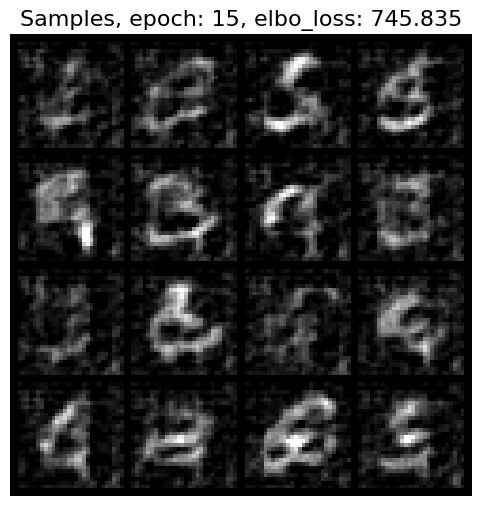

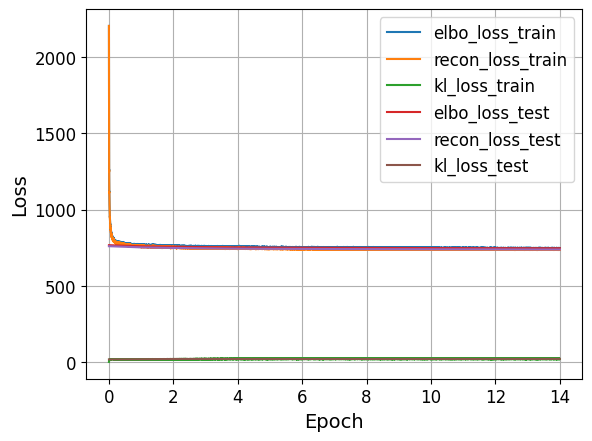

End of the training


In [201]:
BATCH_SIZE = 32 
EPOCHS = 15
LR = 1e-4
N_LATENS = 32
BETA = 0.4

centered_train_data = train_data * 2 - 1
centered_test_data = test_data * 2 - 1

train_loader = data.DataLoader(centered_train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(centered_test_data, batch_size=BATCH_SIZE)

model = GammaConvResNetVAE((1, 28, 28), N_LATENS, BETA)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

train_model(
    model,
    train_loader,
    test_loader,
    epochs=EPOCHS,
    optimizer=optimizer,
    device=DEVICE,
    n_samples=16,
    visualize_samples=True,
    loss_key="elbo_loss"
)

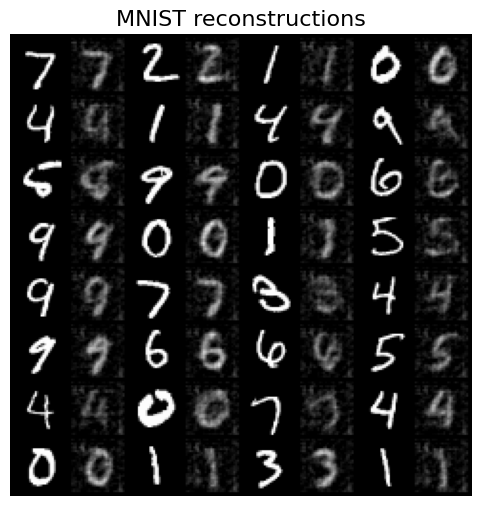

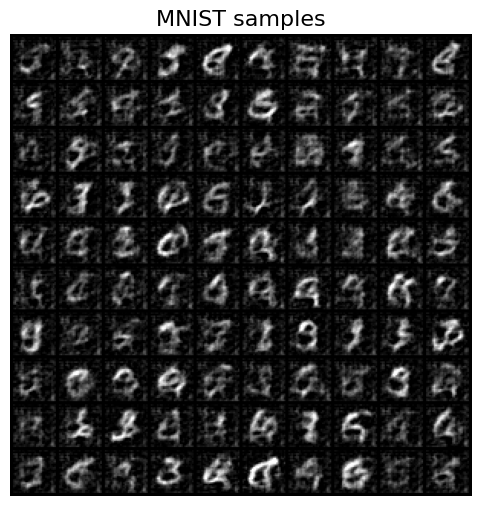

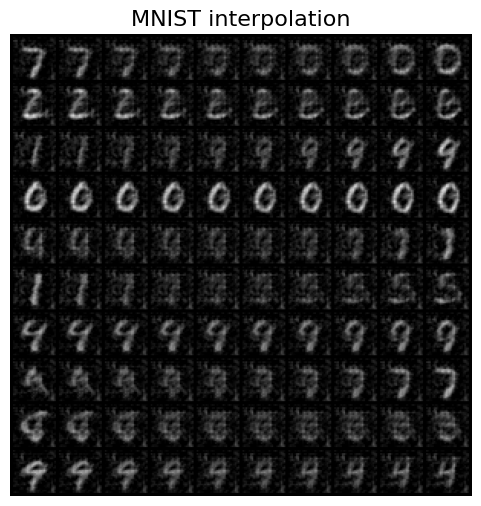

In [202]:
samples = model.sample(100)

x = next(iter(test_loader))[:50]

x = x.to(model.device)

with torch.no_grad():
    z, _ = model.encoder(x)
    x_recon = torch.clamp(model.decoder(z), -1, 1)
reconstructions = torch.stack((x, x_recon), dim=1).view(-1, 1, 28, 28) * 0.5 + 0.5
reconstructions = reconstructions.cpu().numpy()

x = next(iter(test_loader))[:20]
x = x.to(model.device)
with torch.no_grad():
    z, _ = model.encoder(x)
    z1, z2 = z.chunk(2, dim=0)
    interps = [model.decoder(z1 * (1 - alpha) + z2 * alpha) for alpha in np.linspace(0, 1, 10)]
    interps = torch.stack(interps, dim=1).view(-1, 1, 28, 28)
    interps = torch.clamp(interps, -1, 1) * 0.5 + 0.5
interps = interps.cpu().numpy()

show_samples(reconstructions, 'MNIST reconstructions')
show_samples(samples, 'MNIST samples')
show_samples(interps, 'MNIST interpolation')

Conclusion: after experiments with several distributioins, we have not obtained better results than simple normal ditribution.